<a href="https://colab.research.google.com/github/pratham-patil64/semanticsegmentation/blob/main/semanticsegmentationworking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 113MB/s]


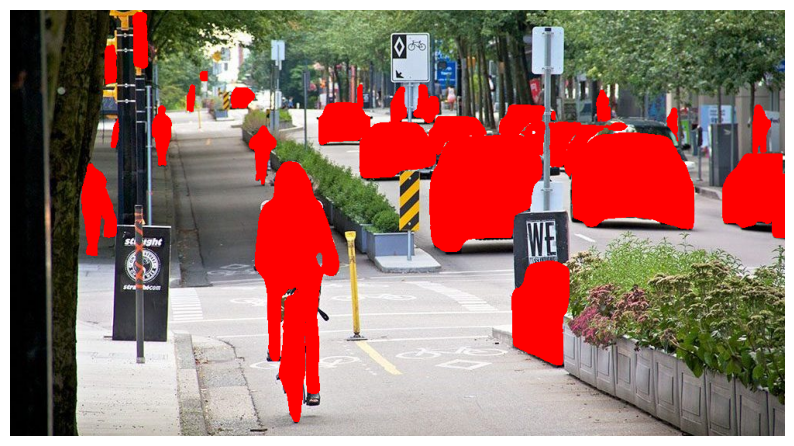

In [ ]:
# Install necessary libraries in Google Colab
!pip install torch torchvision opencv-python numpy matplotlib pillow

import cv2
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor (Normalization included)
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

def load_model():
    """Load pre-trained Mask R-CNN model."""
    model = maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    return model

def segment_image(model, image_tensor):
    """Perform segmentation on the input image."""
    with torch.no_grad():
        predictions = model(image_tensor)
    return predictions

def compute_metrics(predictions, ground_truth):
    """Compute IoU and Dice Score for segmentation evaluation."""
    pred_masks = predictions[0]['masks'].cpu().numpy()
    gt_masks = ground_truth.cpu().numpy()

    intersection = np.logical_and(pred_masks, gt_masks).sum()
    union = np.logical_or(pred_masks, gt_masks).sum()

    iou = intersection / union if union > 0 else 0
    dice = (2 * intersection) / (pred_masks.sum() + gt_masks.sum()) if (pred_masks.sum() + gt_masks.sum()) > 0 else 0

    return iou, dice

def visualize_results(image_path, predictions, threshold=0.5):
    """Visualize segmentation results."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    masks = predictions[0]['masks'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    for i in range(len(masks)):
        if scores[i] > threshold:
            mask = masks[i, 0]  # Get the first channel
            mask = (mask > 0.5).astype(np.uint8) * 255
            image[mask == 255] = (255, 0, 0)  # Color the segmentation mask

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

def main(image_path, ground_truth=None):
    image_tensor = preprocess_image(image_path)
    model = load_model()
    predictions = segment_image(model, image_tensor)
    visualize_results(image_path, predictions)

    if ground_truth is not None:
        iou, dice = compute_metrics(predictions, ground_truth)
        print(f"IoU Score: {iou:.4f}")
        print(f"Dice Score: {dice:.4f}")

if __name__ == "__main__":
    image_path = "cycle.jpg"  # Change this to your image path
    ground_truth = None  # Provide ground truth mask if available
    main(image_path, ground_truth)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 131MB/s]


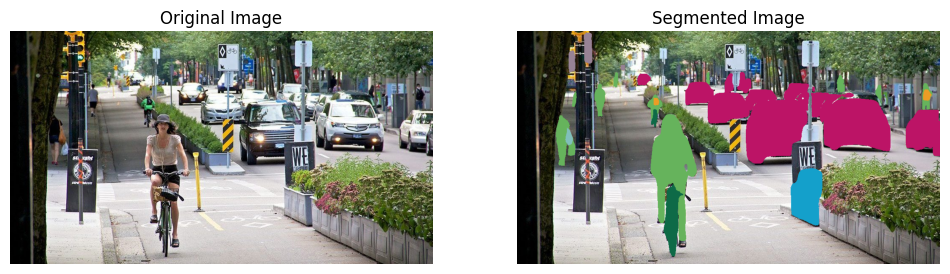

In [ ]:
import cv2
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor (Normalization included)
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

def load_model(model_name="maskrcnn"):
    """Load a segmentation model based on user choice."""
    if model_name == "maskrcnn":
        model = maskrcnn_resnet50_fpn(pretrained=True)
    elif model_name == "deeplabv3":
        model = deeplabv3_resnet50(pretrained=True)
    else:
        raise ValueError("Invalid model name. Choose 'maskrcnn' or 'deeplabv3'.")
    model.eval()
    return model

def segment_image(model, image_tensor):
    """Perform segmentation on the input image."""
    with torch.no_grad():
        predictions = model(image_tensor)
    return predictions

def visualize_results(image_path, predictions, threshold=0.5):
    """Visualize original image and segmentation results side by side."""
    # Load original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Copy image for visualization
    segmented_image = original_image.copy()

    masks = predictions[0]['masks'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Predefined colors for consistent labeling
    np.random.seed(42)
    unique_labels = np.unique(labels)
    colors = {label: tuple(np.random.randint(0, 255, 3)) for label in unique_labels}

    for i in range(len(masks)):
        if scores[i] > threshold:
            mask = masks[i, 0]  # Get the first channel
            mask = (mask > 0.5).astype(np.uint8) * 255
            color = colors[labels[i]]  # Assign same color to same object type
            segmented_image[mask == 255] = color  # Apply unique color to each class mask

    # Display original and segmented images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(segmented_image)
    ax[1].set_title("Segmented Image")
    ax[1].axis("off")

    plt.show()

def main(image_path, model_name="maskrcnn"):
    image_tensor = preprocess_image(image_path)
    model = load_model(model_name)
    predictions = segment_image(model, image_tensor)
    visualize_results(image_path, predictions)

if __name__ == "__main__":
    image_path = "cycle.jpg"  # Change this to your image path
    model_name = "maskrcnn"  # Choose "maskrcnn" or "deeplabv3"
    main(image_path, model_name)


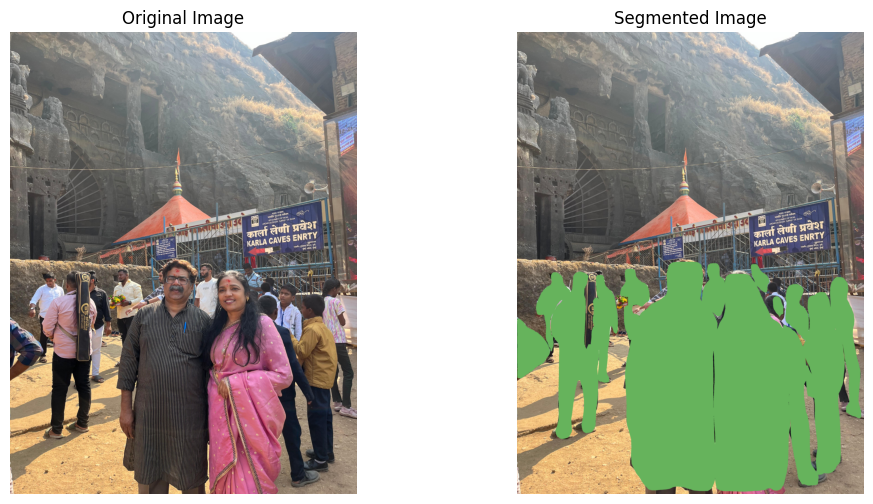

In [ ]:
import cv2
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor (Normalization included)
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

def load_model(model_name="maskrcnn"):
    """Load a segmentation model based on user choice."""
    if model_name == "maskrcnn":
        model = maskrcnn_resnet50_fpn(pretrained=True)
    elif model_name == "deeplabv3":
        model = deeplabv3_resnet50(pretrained=True)
    else:
        raise ValueError("Invalid model name. Choose 'maskrcnn' or 'deeplabv3'.")
    model.eval()
    return model

def segment_image(model, image_tensor):
    """Perform segmentation on the input image."""
    with torch.no_grad():
        predictions = model(image_tensor)
    return predictions

def visualize_results(image_path, predictions, threshold=0.5):
    """Visualize original image and segmentation results side by side."""
    # Load original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Copy image for visualization
    segmented_image = original_image.copy()

    masks = predictions[0]['masks'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Predefined colors for consistent labeling
    np.random.seed(42)
    unique_labels = np.unique(labels)
    colors = {label: tuple(np.random.randint(0, 255, 3)) for label in unique_labels}

    for i in range(len(masks)):
        if scores[i] > threshold:
            mask = masks[i, 0]  # Get the first channel
            mask = (mask > 0.5).astype(np.uint8) * 255
            color = colors[labels[i]]  # Assign same color to same object type
            segmented_image[mask == 255] = color  # Apply unique color to each class mask

    # Display original and segmented images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(segmented_image)
    ax[1].set_title("Segmented Image")
    ax[1].axis("off")

    plt.show()

def main(image_path, model_name="maskrcnn"):
    image_tensor = preprocess_image(image_path)
    model = load_model(model_name)
    predictions = segment_image(model, image_tensor)
    visualize_results(image_path, predictions)

if __name__ == "__main__":
    image_path = "ekvira.jpg"  # Change this to your image path
    model_name = "maskrcnn"  # Choose "maskrcnn" or "deeplabv3"
    main(image_path, model_name)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 97.7MB/s]


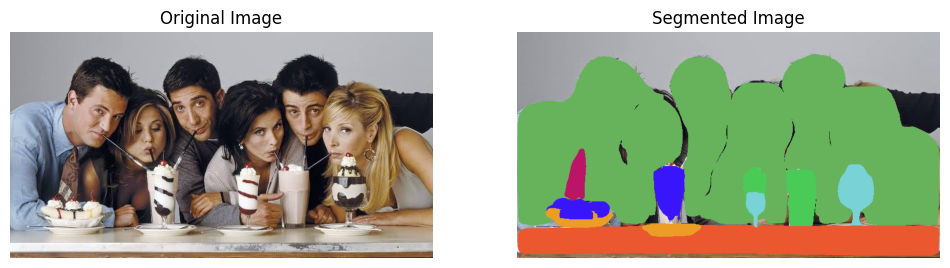

In [2]:
import cv2
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(image_path):
    """Load and preprocess the image."""
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor (Normalization included)
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

def load_model(model_name="maskrcnn"):
    """Load a segmentation model based on user choice."""
    if model_name == "maskrcnn":
        model = maskrcnn_resnet50_fpn(pretrained=True)
    elif model_name == "deeplabv3":
        model = deeplabv3_resnet50(pretrained=True)
    else:
        raise ValueError("Invalid model name. Choose 'maskrcnn' or 'deeplabv3'.")
    model.eval()
    return model

def segment_image(model, image_tensor):
    """Perform segmentation on the input image."""
    with torch.no_grad():
        predictions = model(image_tensor)
    return predictions

def visualize_results(image_path, predictions, threshold=0.5):
    """Visualize original image and segmentation results side by side."""
    # Load original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Copy image for visualization
    segmented_image = original_image.copy()

    masks = predictions[0]['masks'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Predefined colors for consistent labeling
    np.random.seed(42)
    unique_labels = np.unique(labels)
    colors = {label: tuple(np.random.randint(0, 255, 3)) for label in unique_labels}

    for i in range(len(masks)):
        if scores[i] > threshold:
            mask = masks[i, 0]  # Get the first channel
            mask = (mask > 0.5).astype(np.uint8) * 255
            color = colors[labels[i]]  # Assign same color to same object type
            segmented_image[mask == 255] = color  # Apply unique color to each class mask

    # Display original and segmented images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(segmented_image)
    ax[1].set_title("Segmented Image")
    ax[1].axis("off")

    plt.show()

def main(image_path, model_name="maskrcnn"):
    image_tensor = preprocess_image(image_path)
    model = load_model(model_name)
    predictions = segment_image(model, image_tensor)
    visualize_results(image_path, predictions)

if __name__ == "__main__":
    image_path = "friends.jpg"  # Change this to your image path
    model_name = "maskrcnn"  # Choose "maskrcnn" or "deeplabv3"
    main(image_path, model_name)
